In [1]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import log_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

#import warnings
#warnings.filterwarnings("ignore")

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED=777
seed_everything(SEED)

torch.__version__

'1.7.0+cu101'

In [2]:
data_path = '../input/lish-moa/'

In [3]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger()
logger.info(f'Set seed: {SEED}')

Set seed: 777


# load df

In [4]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [5]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
14261,id_a6a4f3626,trt_cp,24,D2,-0.3265,0.1577,-0.3381,0.1789,0.2595,0.7117,...,0,0,0,0,0,0,0,0,0,0
14266,id_a6b456ebb,trt_cp,24,D1,-0.7239,0.0713,0.2250,0.5864,2.6280,-0.4762,...,0,0,0,0,0,0,0,0,0,0
5119,id_3bd739795,trt_cp,24,D1,0.5283,1.2350,2.7150,-0.0206,0.5865,0.2824,...,0,0,0,0,0,0,0,0,0,0
692,id_07b7426b2,trt_cp,24,D1,-0.2856,-0.6573,1.8890,-0.3083,-0.5899,0.5369,...,0,0,0,0,0,0,0,0,0,0
6833,id_4fbf1ada4,trt_cp,72,D2,0.9492,-0.5027,-0.0934,-2.2830,-0.1903,0.0230,...,0,0,0,0,0,0,0,0,0,0
7051,id_52620ac73,trt_cp,24,D1,-0.4717,-0.2592,-0.5129,0.0462,0.5863,-0.6585,...,0,0,0,0,0,0,0,0,0,0
13131,id_995a3b2d4,trt_cp,48,D1,2.4190,-1.1380,-0.4596,-0.1602,2.5480,1.5230,...,0,0,0,0,0,0,0,0,0,0
2435,id_1c33757b3,trt_cp,24,D1,-0.0171,-0.0432,-0.4036,-0.6486,-0.7183,-0.5947,...,0,0,0,0,0,0,0,0,0,0
10021,id_7514b50fb,trt_cp,48,D1,0.5772,0.8006,1.5080,-0.8161,-0.1879,-0.1965,...,0,0,0,0,0,0,0,0,0,0
13768,id_a0ad27715,trt_cp,48,D2,0.2120,0.2485,1.0300,-1.0730,-0.0180,-1.7210,...,0,0,0,0,0,0,0,0,0,0


# cv

In [6]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

C:\Users\utl\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass shuffle=True, random_state=777 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [7]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [8]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [9]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [25]:
class CFG:
    max_grad_norm = 1000
    gradient_accumulation_steps = 5
    hidden_size = 256
    dropout = 0.5
    lr = 1e-2
    wd = 1e-6
    bs = 32
    epochs = 25
    feature_cols = feature_cols
    target_cols = y_keys 

In [26]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.ReLU(),
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
            nn.ReLU(),
            nn.Linear(cfg.hidden_size, len(cfg.target_cols)),
        )

    def forward(self, x):
        x = self.mlp(x)
        return x

In [27]:
def metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(ys * np.log(preds) + (1 - ys) * np.log(1 - preds),
                             axis=1), axis=0)
    return score

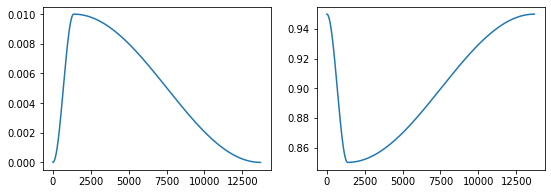

In [28]:
%%capture --no-display
# show_learning_rate_scheduler
cfg = CFG
model = MLP(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                          pct_start=0.1,
                                          div_factor=1e3,
                                          max_lr=1e-2,
                                          epochs=cfg.epochs,
                                          steps_per_epoch=len(trn_loader))


def show_learning_rate_scheduler():
    lrs = []
    moms = []
    for i in range(cfg.epochs * len(trn_loader)):
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.subplot(121)
    plt.plot(lrs)
    plt.subplot(122)
    plt.plot(moms)


show_learning_rate_scheduler()

# train

In [29]:
def trn_fn(trn_loader, model, optimizer, scheduler):

    losses = AverageMeter()

    model.train()

    for i, (xs, ys) in enumerate(trn_loader):

        batch_size = len(xs)

        pred = model(xs)

        loss = nn.BCEWithLogitsLoss()(pred, ys)
        losses.update(loss.item(), batch_size)

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps

        loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)

        if (i + 1) % CFG.gradient_accumulation_steps == 0:  
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
    return losses.avg


def val_fn(val_loader, model):
    losses = AverageMeter()

    model.eval()
    val_preds = []

    for i, (xs, ys) in enumerate(val_loader):

        batch_size = len(xs)

        with torch.no_grad():
            pred = model(xs)

        loss = nn.BCEWithLogitsLoss()(pred, ys)
        losses.update(loss.item(), batch_size)

        val_preds.append(pred.sigmoid().detach().cpu().numpy())

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps

    val_preds = np.concatenate(val_preds)

    return losses.avg, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)

        preds.append(pred.sigmoid().detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [30]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                              pct_start=0.1,
                                              div_factor=1e3,
                                              max_lr=1e-2,
                                              epochs=cfg.epochs,
                                              steps_per_epoch=len(trn_loader))

    # log
    log_df = pd.DataFrame(columns=(['EPOCH'] + ['TRAIN_LOSS'] +
                                   ['VALID_LOSS']))

    # train & validate
    best_loss = np.inf
    for epoch in range(cfg.epochs):
        trn_loss = trn_fn(trn_loader, model, optimizer, scheduler)
        val_loss, val_preds = val_fn(val_loader, model)
        
        log_row = {
            'EPOCH': epoch,
            'TRAIN_LOSS': trn_loss,
            'VALID_LOSS': val_loss,
        }
        log_df = log_df.append(pd.DataFrame(log_row, index=[0]), sort=False)
        if val_loss < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_loss}')
            best_loss = val_loss
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")
            
            
    score = metric(oof[val_idx], trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))
    
    
    folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):   
        
        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

        
    score = metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions

In [31]:
oof, predictions = run_kfold_nn(CFG, trn_df, test_df, CFG.feature_cols, CFG.target_cols, n_fold=5)

C:\Users\utl\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass shuffle=True, random_state=777 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
fold 0
epoch0 save best model... 0.5274147720706218
epoch1 save best model... 0.15679465548595697
epoch2 save best model... 0.06513647147897707
epoch3 save best model... 0.0435681625555751
epoch4 save best model... 0.034720845017285173
epoch5 save best model... 0.029245986662177127
epoch6 save best model... 0.026937139273572348
epoch7 save best model... 0.025776170625230445
epoch8 save best model... 0.024707350599874396
epoch9 save best model... 0.024152764615206077
epoch10 save best model... 0.023900348088090946
epoch13 save best model... 0.02378119753762774
epoch14 save best model... 0.023734832646702852
epoch15 save best model... 0.023690943578618805
epoch17 save best model... 0.023687418616442583
epoch18 save best model... 0.023649906776930314
epoc

In [32]:
trn_df[y_keys] = oof
trn_df[['sig_id'] + y_keys].to_csv('oof.csv', index=False)

test_df[y_keys] = pd.DataFrame(predictions)
test_df[['sig_id'] + y_keys].to_csv('pred.csv', index=False)

In [33]:
# Final result with 'cp_type'=='ctl_vehicle' data
result = trn_tar_df.drop(columns=y_keys).merge(trn_df[['sig_id']+y_keys], on='sig_id', how='left').fillna(0)

ys = trn_tar_df[y_keys].values
preds = result[y_keys].values

score = metric(preds, ys)
logger.info(f"Final result: {score}")

Final result: 0.015822572460770578


In [34]:
sub = sub_df.drop(columns=y_keys).merge(test_df[['sig_id'] + y_keys], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)
sub.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.001173,0.001177,0.001564,0.014063,0.023031,0.005968,0.003795,0.006416,0.000784,...,0.000431,0.001073,0.003193,0.001119,0.001969,0.000422,0.002163,0.001836,0.002235,0.002109
1,id_001897cda,0.001259,0.001393,0.002097,0.006803,0.009985,0.004367,0.003573,0.008062,0.001706,...,0.000675,0.002279,0.004023,0.001415,0.015506,0.000653,0.026361,0.002028,0.002547,0.002742
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.001069,0.001090,0.002067,0.013045,0.015193,0.004396,0.003495,0.006137,0.000913,...,0.000555,0.002529,0.003726,0.011779,0.007242,0.000486,0.004390,0.002213,0.002742,0.002540
4,id_0027f1083,0.001239,0.001207,0.001713,0.017508,0.025851,0.006534,0.004715,0.005936,0.000801,...,0.000453,0.001326,0.003541,0.002991,0.001807,0.000426,0.001249,0.002052,0.001987,0.002196
